# **1. Environment setting**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# --- 1. Force Install Compatible Libraries ---
!pip uninstall -y transformers datasets huggingface_hub accelerate peft
# This MUST be the first cell to run
# Install huggingface_hub FIRST to avoid 'HfFolder' import error
!pip install "huggingface_hub==0.16.4"
# Install the rest of the compatible set
!pip install "transformers==4.30.0" "datasets==2.12.0" "accelerate==0.20.3" "peft==0.4.0"

Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
Found existing installation: datasets 4.1.1
Uninstalling datasets-4.1.1:
  Successfully uninstalled datasets-4.1.1
Found existing installation: huggingface-hub 1.0.0rc2
Uninstalling huggingface-hub-1.0.0rc2:
  Successfully uninstalled huggingface-hub-1.0.0rc2
Found existing installation: accelerate 1.9.0
Uninstalling accelerate-1.9.0:
  Successfully uninstalled accelerate-1.9.0
Found existing installation: peft 0.16.0
Uninstalling peft-0.16.0:
  Successfully uninstalled peft-0.16.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires datasets, which is not installed.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, whi

In [3]:
# Step 2: Import libraries
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import EarlyStoppingCallback
import numpy as np
import torch # أضفتها احتياطاً

print("All libraries imported successfully!")

2025-10-23 17:42:42.839817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761241363.063047      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761241363.128364      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully!


# **2. Setup and Data Loading**

In [4]:

neg_df = pd.read_csv(r"/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_negative_20190413.tsv", sep='\t', header=None, names=["raw"])
pos_df = pd.read_csv(r"/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_positive_20190413.tsv", sep='\t', header=None, names=["raw"])
pos_df.head()

,raw
pos,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...
pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...
pos,من الخير نفسه 💛
pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...
pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...


In [5]:
neg_df = neg_df.reset_index().rename(columns={"index": "label"})
pos_df = pos_df.reset_index().rename(columns={"index": "label"})
combined_df = pd.concat([neg_df, pos_df], ignore_index=True)
combined_df.head()

,label,raw
0,neg,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...
1,neg,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...
2,neg,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال و...
3,neg,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين ع...
4,neg,الدودو جايه تكمل علي 💔


# **3. Exploratory Data Analysis (EDA)**

In [6]:
# --- Dataset Overview ---

# Get the total number of records
total_rows = combined_df.shape[0]

# Get the number of unique classes (sentiments)
unique_classes = combined_df["label"].nunique()

# Get the count of records for each class (Positive vs. Negative)
class_counts = combined_df["label"].value_counts()

# --- Display Basic Statistics ---
print("🔎 Data Analysis:\n")
print(f"Total number of records: {total_rows}")
print(f"Number of unique classes (sentiments): {unique_classes}")
print("\n📊 Class Distribution (Records per class):")
print(class_counts)

# --- Text Length Analysis ---

# Calculate the length of each text (number of characters)
# We assume the raw text is in the 'raw' column
combined_df["text_length"] = combined_df["raw"].str.len()

# Calculate text length statistics
avg_length = combined_df["text_length"].mean()
max_length = combined_df["text_length"].max()
min_length = combined_df["text_length"].min()

print(f"\n✍️ Average text length: {avg_length:.2f} characters")
print(f"Longest text (max length): {max_length} characters")
print(f"Shortest text (min length): {min_length} characters")

🔎 Data Analysis:

Total number of records: 45275
Number of unique classes (sentiments): 2

📊 Class Distribution (Records per class):
label
pos    22761
neg    22514
Name: count, dtype: int64

✍️ Average text length: 67.67 characters
Longest text (max length): 8109 characters
Shortest text (min length): 5 characters


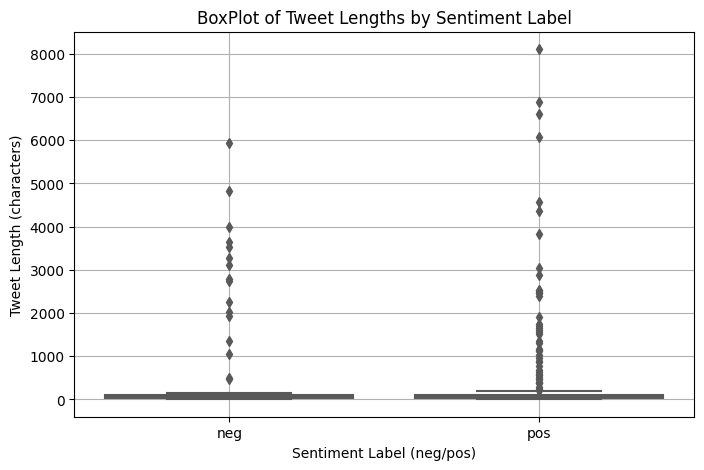

In [7]:
# --- Text Length Distribution by Sentiment ---
combined_df["text_length"] = combined_df["raw"].str.len()

# رسم BoxPlot لكل كلاس
plt.figure(figsize=(8, 5))
sns.boxplot(data=combined_df, x="label", y="text_length", palette="Set2")
plt.title("BoxPlot of Tweet Lengths by Sentiment Label")
plt.xlabel("Sentiment Label (neg/pos)")
plt.ylabel("Tweet Length (characters)")
plt.grid(True)
plt.show()

In [8]:
# --- 4. Handling Long/Concatenated Tweets (Data Cleaning) ---
# Note: This step assumes long tweets are concatenated records separated by 'pos' or 'neg' strings.

# 1. Filter for potentially concatenated tweets (e.g., length > 300)
long_tweets = combined_df[combined_df["text_length"] > 300]

# 2. List to hold the new, split tweets
split_tweets = []

# 3. Define a function to split the combined tweets
def split_combined_tweets(text, label):
    # Set the delimiter based on the row's *own* label
    delimiter = 'pos' if label == 'pos' else 'neg'
    
    parts = text.split(delimiter)
    tweets = []
    
    for part in parts:
        clean = part.strip()
        
        # Additional check to ignore empty or very short parts
        if len(clean) > 20: 
            # CRITICAL LOGIC: Assigns the *original* label to *all* split parts
            tweets.append({'raw': clean, 'label': label})
            
    return tweets

# 4. Apply the splitting function to every long tweet
for _, row in long_tweets.iterrows():
    split_tweets.extend(split_combined_tweets(row['raw'], row['label']))

# 5. Create a new DataFrame from the split tweets
final_df = pd.DataFrame(split_tweets)

# 6. Recalculate the text length for the new, split tweets
final_df["text_length"] = final_df["raw"].str.len()

# 7. Display a sample to verify
print("Sample of the newly split tweets:")
final_df.head(100)

Sample of the newly split tweets:


,raw,label,text_length
0,الله يرد خطاك لدروب خلانك 🥀 لعيون ماتنساك لو ط...,neg,55
1,أصبحت سلوكيات من ضيع ثقافته ليحاول ان يكون ندا...,neg,115
2,ما رح اتخلى عنك ❤ حتى لو بدي ازعل واتوجع منك 💔...,neg,91
3,تدرين وشي المتعه حبيبتي؟نمسك اقرب زاويه وادخل ...,neg,115
4,مش عارفة! عالأغلب الأجانب straight to the poin...,neg,103
...,...,...,...
95,مهما إبتعدت ومهما طال غيابڪ 💔 يڪفينى اننى ڪلما...,neg,73
96,إن لم تكونوا أوفياء ، فلا تعبثوا بقلوب الأنقياء 🥀,neg,49
97,رأيكم في اداء الهلال اليوم أمام الأهلي ❓,neg,40
98,🚫250 طفل فلسطيني يقبعون خلف سجون الاحتلال 🚫 طف...,neg,104


In [9]:
# --- 5. Final Data Consolidation ---

# 1. Remove the long tweets (which we already processed) from the original dataframe
# We keep only tweets with length <= 300 characters
combined_df_clean = combined_df[combined_df["text_length"] <= 300].copy()

# 2. Ensure both dataframes have the same columns before merging (raw and label only)
combined_df_clean = combined_df_clean[["raw", "label"]]
final_df = final_df[["raw", "label"]] # 'final_df' is from the previous cell

# 3. Concatenate the clean (short) tweets with the newly split (formerly long) tweets
merged_df = pd.concat([combined_df_clean, final_df], ignore_index=True)

# 4. Recalculate the text_length for the new, complete dataframe
merged_df["text_length"] = merged_df["raw"].str.len()

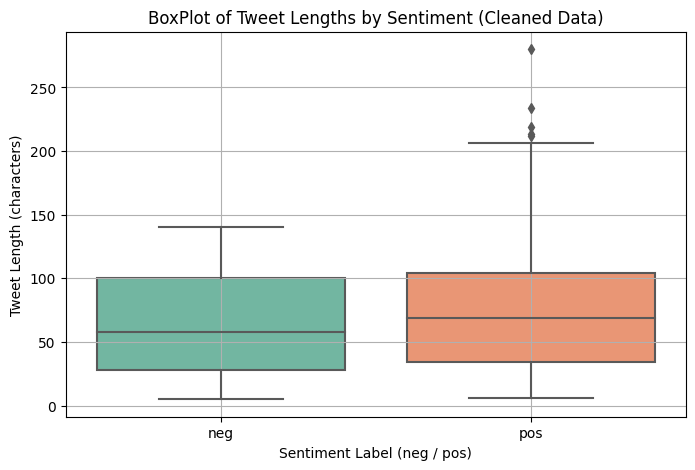

In [10]:
# --- 6. Final Data Visualization (Post-Cleaning) ---

# Create a BoxPlot for tweet lengths by sentiment on the CLEANED data
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df, x="label", y="text_length", palette="Set2")

# Set titles and labels (Updated to reflect cleaned data)
plt.title("BoxPlot of Tweet Lengths by Sentiment (Cleaned Data)")
plt.xlabel("Sentiment Label (neg / pos)")
plt.ylabel("Tweet Length (characters)")

plt.grid(True)
plt.show()

In [11]:
# استخراج التغريدات التي طولها أكبر من 200 حرف
long_tweets_200 = merged_df[merged_df["text_length"] > 200]

# عرض أول 10 منها كمثال
long_tweets_200[['label', 'raw']].head(10)

,label,raw
23360,pos,مهما كنت صادقا في حديثك ستجد من يكذبك ومهما كا...
24960,pos,إلى الذين يفعلون المعروف دون انتظار الرد الذين...
29541,pos,﴿وجزاهم بما صبروا جنة وحريرا ﴾ على سبيل الراح...
32633,pos,اللهم من نام وبخاطره أمر ، فصبحه وقد غدى أمره ...
33090,pos,أبواب السعادة كثيرة ولكن أحيانا البشر يقفون ع...
40288,pos,يوما ما ستبدو فخورا بكل الصعاب التي واجهت النص...


In [12]:
# --- 7. Final Dataset Statistics (Post-Cleaning) ---

# Get the total number of records after cleaning
total_rows = merged_df.shape[0]

# Get the number of unique classes
unique_classes = merged_df["label"].nunique()

# Get the distribution of tweets by sentiment
class_counts = merged_df["label"].value_counts()

# Get text length statistics
avg_length = merged_df["text_length"].mean()
max_length = merged_df["text_length"].max()
min_length = merged_df["text_length"].min()

# --- Display Final Results ---
print(f"📌 Total number of records (after cleaning): {total_rows}")
print(f"📌 Number of unique classes: {unique_classes}")
print("\n📊 Tweet distribution by class:")
print(class_counts)
print(f"\n✍️ Average tweet length: {avg_length:.2f} characters")
print(f"📏 Longest tweet: {max_length} characters")
print(f"📉 Shortest tweet: {min_length} characters")

📌 Total number of records (after cleaning): 46756
📌 Number of unique classes: 2

📊 Tweet distribution by class:
label
pos    23726
neg    23030
Name: count, dtype: int64

✍️ Average tweet length: 65.24 characters
📏 Longest tweet: 280 characters
📉 Shortest tweet: 5 characters


In [13]:
# --- 8. Duplicate Records Analysis ---

from collections import Counter

# Extract texts from the appropriate column (e.g., "text" or "raw")
texts = merged_df["raw"]  # Change the column name if needed

# Use Counter to calculate frequencies
text_counts = Counter(texts)

# Get only the texts that are duplicated (count > 1)
duplicates = [text for text, count in text_counts.items() if count > 1]

# Print the number of *unique* duplicate texts
print(f"🔁 Number of unique duplicate texts: {len(duplicates)}")

# Print the total number of *rows* that are duplicates
num_duplicate_rows = texts.duplicated().sum()
print(f"📄 Total number of duplicate rows: {num_duplicate_rows}")

# Calculate and print the percentage of duplicates
total_rows = len(texts)
duplicate_ratio = (num_duplicate_rows / total_rows) * 100
print(f"📉 Percentage of duplicate data: {duplicate_ratio:.2f}%")

🔁 Number of unique duplicate texts: 4357
📄 Total number of duplicate rows: 16552
📉 Percentage of duplicate data: 35.40%


In [14]:
merged_df = merged_df.drop_duplicates(subset="raw", keep="first")

# **4. Model Building & Evaluation**

In [15]:
from sklearn.model_selection import train_test_split

shuffled_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, val_df = train_test_split(
    shuffled_df, 
    test_size=0.2, 
    stratify=shuffled_df["label"], 
    random_state=42
)

In [16]:
# --- 5. Prepare Data for Hugging Face (DatasetDict) ---

# 1. Convert the training and validation DataFrames to Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# 2. Create a DatasetDict object containing 'train' and 'validation' splits
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

# 3. Drop unimportant columns (keep only 'raw' and 'label')
# This list comprehension finds all columns that are NOT 'raw' or 'label'
columns_to_remove = [col for col in dataset['train'].column_names if col not in ['raw', 'label']]
dataset = dataset.remove_columns(columns_to_remove)

# 4. Display information to verify
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['raw', 'label'],
        num_rows: 24163
    })
    validation: Dataset({
        features: ['raw', 'label'],
        num_rows: 6041
    })
})


In [17]:
# استخدم نموذج BERT مدرّب مسبقًا على اللغة العربية
model_name = "UBC-NLP/MARBERTv2"

# تحميل التوكنـايزر
tokenizer = AutoTokenizer.from_pretrained(model_name)

# تحميل النموذج وتحديد عدد التصنيفات (مثلاً: 0 = neg, 1 = pos)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at UBC-NLP/MARBERTv2 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [18]:
def clean_dataset(ds):
    def convert_label(example):
        return {"label": 0 if example["label"] == "neg" else 1}
    ds = ds.map(convert_label)
    return ds

dataset_cleaned = DatasetDict({
    "train": clean_dataset(dataset["train"]),
    "validation": clean_dataset(dataset["validation"])
})

Map:   0%|          | 0/24163 [00:00<?, ? examples/s]

Map:   0%|          | 0/6041 [00:00<?, ? examples/s]

In [19]:
# Step 7: Tokenize your Arabic dataset

def preprocess_and_tokenize(example):
    #cleaned_text = remove_stopwords(example["raw"])
    #cleaned_text = remove_custom_stopwords(example["raw"])
    cleaned_text =  example["raw"]  # بدون إزالة stopwords
    return tokenizer(cleaned_text, truncation=True, padding=True, max_length=512)

tokenized_datasets = dataset_cleaned.map(preprocess_and_tokenize)

Map:   0%|          | 0/24163 [00:00<?, ? examples/s]

Map:   0%|          | 0/6041 [00:00<?, ? examples/s]

In [20]:
# --- 10. Configure Trainer (Recommended Version) ---

# 1. Define the Data Collator
# This is CRITICAL for padding batches dynamically
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 2. Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=250,
    learning_rate=2e-5,
    
    # --- Added Suggestions ---
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",        # Save at the end of each epoch
    load_best_model_at_end=True,  # Load the best model (by default, based on loss)
    metric_for_best_model="accuracy", # Optional: Tell it to use accuracy
    report_to="none"              # Good choice for Kaggle to avoid wandb errors
)

# 3. Define Metrics Function (Your function is perfect, no changes)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    acc = accuracy_score(labels, preds)
    
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

# 4. Define Early Stopping Callback
# (Assumes you imported EarlyStoppingCallback from transformers)
early_stopping = EarlyStoppingCallback(early_stopping_patience=2) # Stops if no improvement after 2 epochs

# 5. Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    
    # --- Added Suggestions ---
    data_collator=data_collator,
    callbacks=[early_stopping]
)

In [21]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.169800,0.159495,0.934448,0.934392,0.934828,0.934221
2,0.123100,0.184232,0.935276,0.935263,0.935232,0.935316
3,0.071100,0.222881,0.933786,0.933750,0.933904,0.933662


TrainOutput(global_step=2268, training_loss=0.13962908872326005, metrics={'train_runtime': 664.1603, 'train_samples_per_second': 109.144, 'train_steps_per_second': 3.415, 'total_flos': 1331070606845760.0, 'train_loss': 0.13962908872326005, 'epoch': 3.0})

In [22]:
# Step 12: Evaluate
results = trainer.evaluate()

# طباعة النتائج بشكل منسق
print("\n📊 نتائج التقييم:")
print(f"- Accuracy   : {results['eval_accuracy']:.2%}")
print(f"- F1 Score   : {results['eval_f1']:.2%}")
print(f"- Precision  : {results['eval_precision']:.2%}")
print(f"- Recall     : {results['eval_recall']:.2%}")


📊 نتائج التقييم:
- Accuracy   : 93.53%
- F1 Score   : 93.53%
- Precision  : 93.52%
- Recall     : 93.53%


# **5. Evaluating Test Set Performance**

In [23]:
trainer.evaluate(eval_dataset=tokenized_datasets["train"])

{'eval_loss': 0.07508638501167297,
 'eval_accuracy': 0.9756652733518189,
 'eval_f1': 0.9756529779195722,
 'eval_precision': 0.9757884839242567,
 'eval_recall': 0.9755689385282023,
 'eval_runtime': 67.7556,
 'eval_samples_per_second': 356.62,
 'eval_steps_per_second': 11.158,
 'epoch': 3.0}

In [24]:
# --- Load Test Data (Original User Version - CONTAINS LOGIC ERROR) ---

# 1. Read the test files
neg_test_df = pd.read_csv(r"/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_negative_20190413.tsv", sep='\t', header=None, names=["raw"])
pos_test_df = pd.read_csv(r"/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_positive_20190413.tsv", sep='\t', header=None, names=["raw"])

# 2. Reset indices and assign 'label' column (THIS IS THE LOGICAL ERROR)
neg_test_df = neg_test_df.reset_index().rename(columns={"index": "label"})
pos_test_df = pos_test_df.reset_index().rename(columns={"index": "label"})

# 3. Combine the data
combined_test_df = pd.concat([neg_test_df, pos_test_df], ignore_index=True)

# 4. Calculate text length
combined_test_df["text_length"] = combined_test_df["raw"].str.len()

# 5. Remove long tweets
cleaned_test_df = combined_test_df[combined_test_df["text_length"] <= 300].copy()
cleaned_test_df.head()

,label,raw,text_length
0,neg,حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭,37
1,neg,واحد تبع النظام السوري يقول أن المخابرات السور...,116
2,neg,الى متى التعامل السئ للخادمات وعدم احترامهم وك...,115
3,neg,رايح جاي ي طحلبي 🐸 #الهلال_الاهلي,33
4,neg,تتمغط ومعها سداع 😫,18


In [25]:
# --- Test Set Statistics ---

# 1. Get the number of records after cleaning
total_test_rows = cleaned_test_df.shape[0]
print(f"📌 Total number of test records (after cleaning): {total_test_rows}")

# 2. Get the number of unique classes
unique_test_classes = cleaned_test_df["label"].nunique()
print(f"📌 Number of unique classes in test data: {unique_test_classes}")

# 3. Get the distribution of tweets by sentiment
class_test_counts = cleaned_test_df["label"].value_counts()
print("📌 Tweet distribution in test data by class:")
print(class_test_counts)

# 4. Get text length statistics
avg_test_length = cleaned_test_df["text_length"].mean()
max_test_length = cleaned_test_df["text_length"].max()
min_test_length = cleaned_test_df["text_length"].min()

print(f"\n🔍 Average tweet length: {avg_test_length:.2f}")
print(f"🔍 Longest tweet: {max_test_length} characters")
print(f"🔍 Shortest tweet: {min_test_length} characters")

📌 Total number of test records (after cleaning): 11508
📌 Number of unique classes in test data: 2
📌 Tweet distribution in test data by class:
label
neg    5766
pos    5742
Name: count, dtype: int64

🔍 Average tweet length: 64.78
🔍 Longest tweet: 140 characters
🔍 Shortest tweet: 6 characters


In [26]:
# --- 13. Final Evaluation on Test Set (Root Cause Fixed) ---

# 1. (THE MISSING STEP YOU FOUND) Convert 'label' from string to integer
label_map = {"neg": 0, "pos": 1}
cleaned_test_df["label"] = cleaned_test_df["label"].map(label_map)

# 2. Create the test Dataset
# We must explicitly select *only* 'raw' and 'label'
final_test_df = cleaned_test_df[["raw", "label"]].copy() 
testing_dataset = Dataset.from_pandas(final_test_df)

# 3. Define the *exact same* tokenization function used in training
def tokenize_function(example):
    return tokenizer(
        example["raw"], 
        truncation=True, 
        padding="max_length",
        max_length=512
    )

# 4. Apply the tokenization (batched=False, just like training)
testing_tokenized_dataset = testing_dataset.map(tokenize_function)

# 5. (CRITICAL FIX) Remove the 'raw' text column
testing_tokenized_dataset = testing_tokenized_dataset.remove_columns(["raw"])

# 6. Use trainer.predict() - This will now work
testing_prediction_output = trainer.predict(testing_tokenized_dataset)

# 7. The results are inside the 'metrics' attribute
testing_results = testing_prediction_output.metrics

# 8. Print the results
print("\n📊 Final Evaluation results on the **Test** data:")
for key, value in testing_results.items():
    # The keys will have 'test_' prefix (e.g., 'test_accuracy')
    print(f"{key}: {value:.4f}")

Map:   0%|          | 0/11508 [00:00<?, ? examples/s]


📊 Final Evaluation results on the **Test** data:
test_loss: 0.1674
test_accuracy: 0.9451
test_f1: 0.9451
test_precision: 0.9451
test_recall: 0.9451
test_runtime: 225.1348
test_samples_per_second: 51.1160
test_steps_per_second: 1.5990


# **6. Save Final Model**

In [27]:
# ---  Save Final Model & Tokenizer ---

# The 'trainer' object already holds the best model
# (because we set load_best_model_at_end=True)

# Define a path to save the model
final_model_path = "/kaggle/working/marbert-arabic-sentiment-v1"

# Save both the model and the tokenizer
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"Model and Tokenizer saved to: {final_model_path}")

Model and Tokenizer saved to: /kaggle/working/marbert-arabic-sentiment-v1
